In [78]:
using LinearAlgebra
using DelimitedFiles
using LsqFit
using Plots
using QuantumOptics
using Statistics

# CO Vibrational Potential on Pt(111) Surface Fit

In [79]:
# read the data from potential_data
data = readdlm("potential_data", skipstart=1)
test_data = readdlm("test.txt", skipstart=1)

x = data[:, 1]
E = data[:, 2]
E_min = minimum(E)

x_test = test_data[:, 1]
E_test = test_data[:, 2]
E_test_min = minimum(E_test)

-2325.27624834

## Validation of DFT

### Simplified squared fit

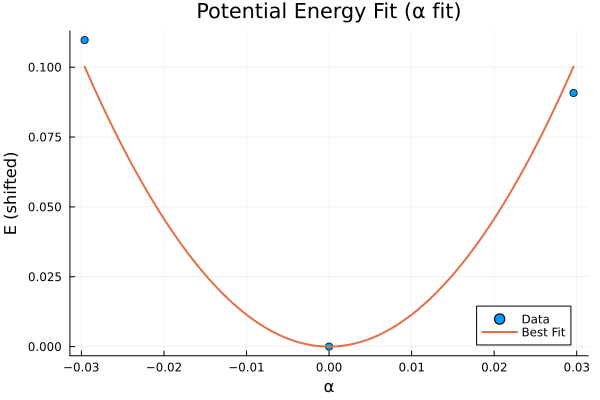

Best fit parameters: [1.2431810198771838e-14, 114.27028459867618]


In [80]:
E_shifted = E .- E_min
E_shifted = E_shifted[2:end-1]
x_ax = [-0.029616460423217354, 0, 0.029616460423217354]

# squared model
model_squared(x, p) = p[1] .+ p[2] .* x .^2
initial_params_squared = [0.0, 100.0]

fit = curve_fit(model_squared, x_ax, E_shifted, initial_params_squared)
best_fit_params = fit.param
println("Best fit parameters: ", best_fit_params)

x_plot = range(minimum(x_ax), stop=maximum(x_ax), length=100)
scatter(x_ax, E_shifted, label="Data", xlabel="α", ylabel="E (shifted)", title="Potential Energy Fit (α fit)")
plot!(x_plot, model_squared(x_plot, best_fit_params), label="Best Fit", linewidth=2)
display(current())

### Verify other mode

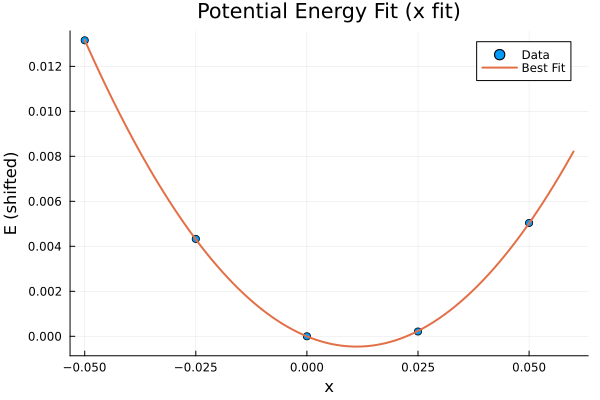

In [81]:
E_test_shifted = E_test .- E_test_min

model_squared(x,p) = p[1] .+ p[2] .* (x .- p[3]) .^2

initial_params_squared = [0.0, 100.0, 0.0]
fit_test = curve_fit(model_squared, x_test, E_test_shifted, initial_params_squared)
fit_test_params = fit_test.param

x_plot_test = range(minimum(x_test), stop=0.06, length=100)
scatter(x_test, E_test_shifted, label="Data", xlabel="x", ylabel="E (shifted)", title="Potential Energy Fit (x fit)")
plot!(x_plot_test, model_squared(x_plot_test, fit_test_params), label="Best Fit", linewidth=2)


### Double_check original mode

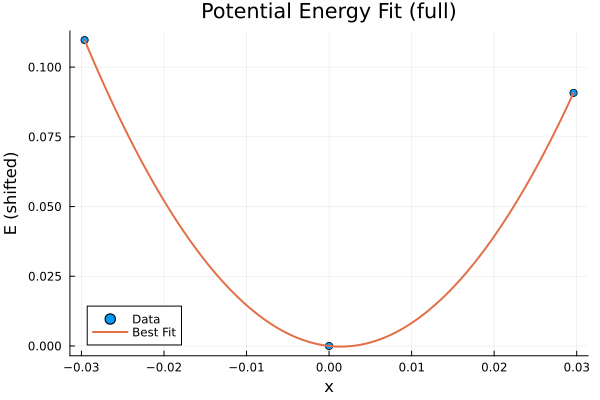

In [82]:
E_s = E .- E_min
x_ax1 = [-0.05923292084643471 ,-0.029616460423217354, 0, 0.029616460423217354, 0.05923292084643471]

x_ax = [-0.029616460423217354, 0, 0.029616460423217354]
E_s = E_s[2:end-1]

initial_params = [0.0, 100.0, 0.0]
fit_full = curve_fit(model_squared, x_ax, E_s, initial_params)
fit_full_params = fit_full.param

x_plot_full = range(minimum(x_ax), stop=maximum(x_ax), length=100)
scatter(x_ax, E_s, label="Data", xlabel="x", ylabel="E (shifted)", title="Potential Energy Fit (full)")
plot!(x_plot_full, model_squared(x_plot_full, fit_full_params), label="Best Fit", linewidth=2)

In [90]:
fit_full_params

3-element Vector{Float64}:
  -0.00022368041980862973
 114.27028459867537
   0.0013990954044383517

### Check validity of all

In [83]:
# perform further calculations
m = 13.585135873543415 # effective mass for the oscillation in units of atomic mass
omega = 265.495409 * 1e-3 # convert meV to eV

# E[eV]=0.5×103.64×m[u]×(0.4037)^2×(x[Angst])^2
# E[eV]≈8.44×m[u]×(x[Angst])^2
coeff_best = best_fit_params[2]
coeff_full = fit_full_params[2]
coeff_test = fit_test_params[2]

for coeff in [coeff_best, coeff_full]
    factor = coeff / (8.44 * m)
    println("Factor: ", factor)
end

Factor: 0.9966137528779263
Factor: 0.9966137528779192


In [84]:
freq_ev_best = 0.658212 * sqrt((coeff_best*2)/(103.64*m))
freq_cm_best = freq_ev_best / (1.23984193e-4)

println("Frequency (cm^-1): ", freq_cm_best)
println("Frequency (eV): ", freq_ev_best)

Frequency (cm^-1): 2138.875141938542
Frequency (eV): 0.2651867084010106


In [85]:
freq_ev_full = 0.658212 * sqrt((coeff_full*2)/(103.64*m))
freq_cm_full = freq_ev_full / (1.23984193e-4)

println("Frequency (cm^-1): ", freq_cm_full)
println("Frequency (eV): ", freq_ev_full)

Frequency (cm^-1): 2138.8751419385344
Frequency (eV): 0.26518670840100966


In [86]:
m_eff = 190.59510644559094
freq_in_ev = 0.658212 * sqrt((coeff_test*2)/(103.64*m_eff))

freq_in_cm = freq_in_ev / (1.23984193e-4)

println("Frequency (cm^-1): ", freq_in_cm)
println("Frequency (eV): ", freq_in_ev)

Frequency (cm^-1): 101.91299582727898
Frequency (eV): 0.012635600543857553


### Polynomial fit

Best fit parameters: [-2323.7387648615027, -0.8761766983958771, 0.189598946260587, -0.00967453013724633]


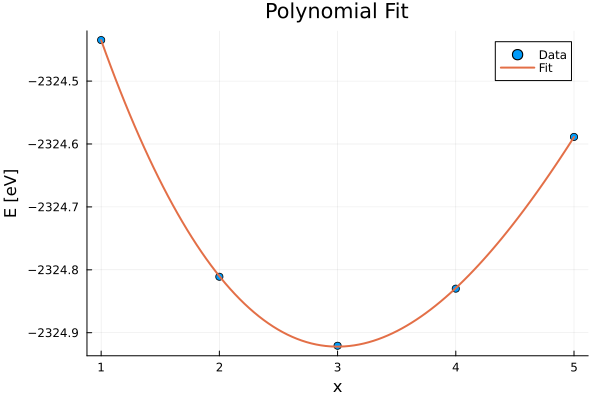

In [87]:
model(x, p) = p[1] .+ p[2] * x .+ p[3] * x.^2 .+ p[4] * x.^3
initial_params = [1000.0, - 1.0, 0.0, 0.0]
fit_result = curve_fit(model, x, E, initial_params)

best_fit_params = fit_result.param

println("Best fit parameters: ", best_fit_params)

# plot the data and the fit
x_plot = range(minimum(x), stop=maximum(x), length=100)
scatter(x, E, label="Data", xlabel="x", ylabel="E [eV]", title="Polynomial Fit")
plot!(x_plot, model(x_plot, best_fit_params), label="Fit", linewidth=2)

### Morse Potential

Best fit Morse parameters: [10.96418420047642, 0.095583781567494, 2.9992735254422755, -2324.9210104815297]


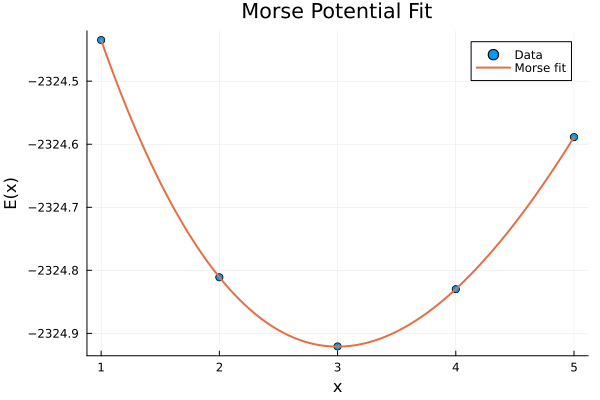

In [88]:
# Morse potential model
morse(x, p) = p[1] .* (1 .- exp.(-p[2] .* (x .- p[3]))).^2 .+ p[4]
# p = [De, a, xe, E0]

# initial guesses
p0 = [maximum(E) - minimum(E), 1.0, mean(x), minimum(E)]

fit = curve_fit(morse, x, E, p0)
params = fit.param
println("Best fit Morse parameters: ", params)

# plot data + fit
x_plot = range(minimum(x), stop=maximum(x), length=200)
scatter(x, E, label="Data", xlabel="x", ylabel="E(x)", title="Morse Potential Fit")
plot!(x_plot, morse(x_plot, params), label="Morse fit", linewidth=2)

### Solve the Schrödinger Equation

In [89]:
# Define grid (1D position basis)
xmin, xmax, N = minimum(x), maximum(x), 400
dx = (xmax - xmin)/N
b = PositionBasis(xmin, xmax, N)
# xgrid

# # Define potential operator from fitted Morse potential
# xgrid = position(b)
# V_vals = morse(xgrid, params)
# V = potentialoperator(b, V_vals)

# # Define kinetic energy operator
# mass = m
m = 13.585135873543415 # effective mass for the oscillation


# T = kinetic(b, mass)   

# # Hamiltonian
# H = T + V

# # Diagonalize Hamiltonian
# energies, states = eigenstates(dense(H))

# # Show first few vibrational energies
# println("First few vibrational levels: ", energies[1:5])


13.585135873543415